In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')

In [2]:
def get_max_drawdown(df,plot=True):
    max_dd_dict = {}

    for strategy in df.columns:

        roll_max = df[strategy].cummax()
        dd = df[strategy]/roll_max - 1.0
        max_dd = dd.cummin()

        max_dd_dict[strategy] = max_dd.min()

        df_graph = pd.concat([dd.to_frame().rename(columns={strategy:"Daily Drawdown"}),
                              max_dd.to_frame().rename(columns={strategy:"MAX Drawdown"})
                                                                                  ],axis=1)
    
        if plot:
            df_graph.plot(figsize=(15,10),title=F"{strategy} Max Drawdown")
        
    return max_dd_dict
        
def get_beta(df):
    df_return = df.pct_change().dropna()

    beta_dict = {}
    for col in df_return.columns:
        x = df_return["SPY"]
        y = df_return[col]

        cov = x.cov(y)

        var = x.var()

        beta_dict[col] = cov/var
    
    return beta_dict

def holding_period_return(df):
    
    return ((df.iloc[-1]/df.iloc[0]) - 1).to_dict()

def volatility(df):
    
    return (df.pct_change().dropna().std() * (12)**(1/2)).to_dict()



strategy = "DBSCAN"

df_aum = pd.read_csv(F"backtest/{strategy}-historical_aum.csv",index_col=0)

df_aum = df_aum.set_index('date')
df_aum.index = pd.to_datetime(df_aum.index,format='%Y-%m-%d')

df_aum = df_aum.rename(columns={'aum':"Benchmark"})
df_aum = df_aum.iloc[1:,:]

df_long = pd.read_csv(F"backtest/{strategy}-long.csv",index_col=0)
df_long = df_long.set_index('date')
df_long.index = pd.to_datetime(df_long.index,format='%Y-%m-%d')
df_long = df_long.iloc[1:,:]

df_short = pd.read_csv(F"backtest/{strategy}-short.csv",index_col=0)
df_short = df_short.set_index('date')
df_short.index = pd.to_datetime(df_short.index,format='%Y-%m-%d')
df_short = df_short.iloc[1:,:]

df_trades = pd.read_csv(F"backtest/{strategy}-number_of_trade.csv",index_col=0)
df_trades = df_trades.set_index('date')
df_trades.index = pd.to_datetime(df_trades.index,format='%Y-%m-%d')
df_trades = df_trades.iloc[1:,:]

df_ls_graph = pd.concat([
                        df_long["amount"].to_frame().rename(columns={"amount":"long"}),
                        df_short["amount"].to_frame().rename(columns={"amount":"short"}),
                        
],axis=1)

df_ls_number_graph = pd.concat([
                        df_long["number"].to_frame().rename(columns={"number":"long"}),
                        df_short["number"].to_frame().rename(columns={"number":"short"}),
                        
],axis=1)

df_ls_number_graph.index = df_ls_number_graph.index.astype(str).str[:10]

<Axes: title={'center': 'DBSCAN L/S # of Holdings'}, xlabel='date'>

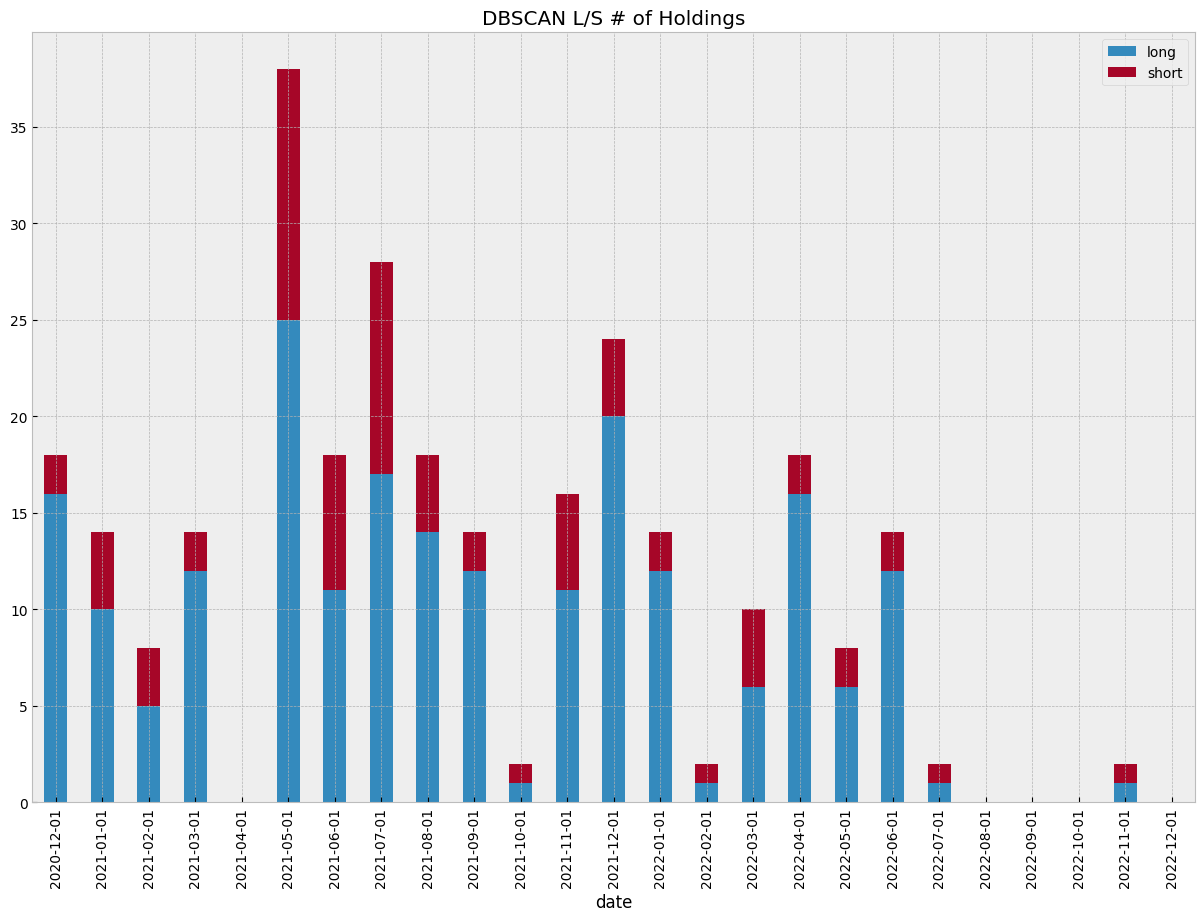

In [3]:
df_ls_number_graph.plot.bar(figsize=(15,10),title=F"{strategy} L/S # of Holdings",stacked=True)

<Axes: title={'center': 'DBSCAN L/S Exposure'}, xlabel='date'>

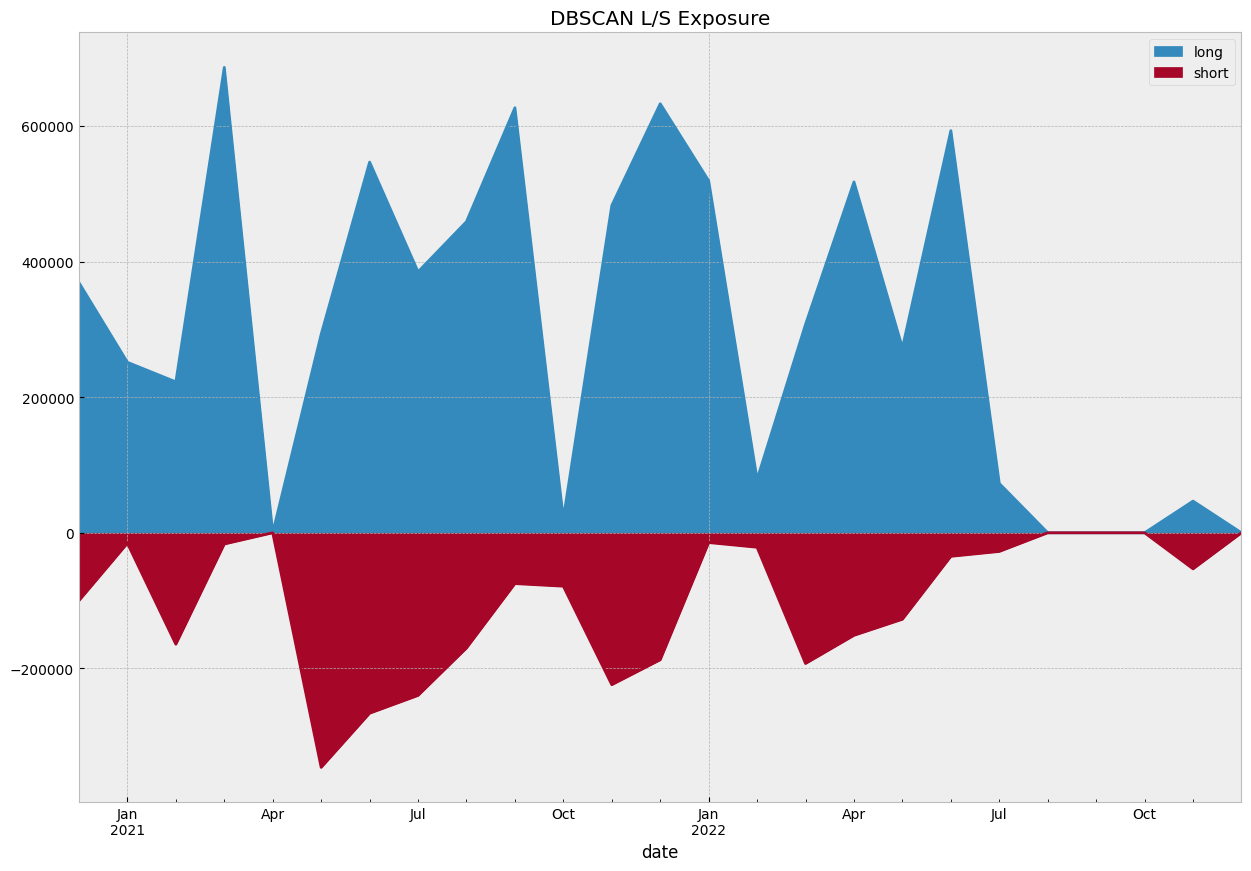

In [4]:
df_ls_graph.plot.area(figsize=(15,10),title=F"{strategy} L/S Exposure")

<Axes: title={'center': 'Wealth Index'}>

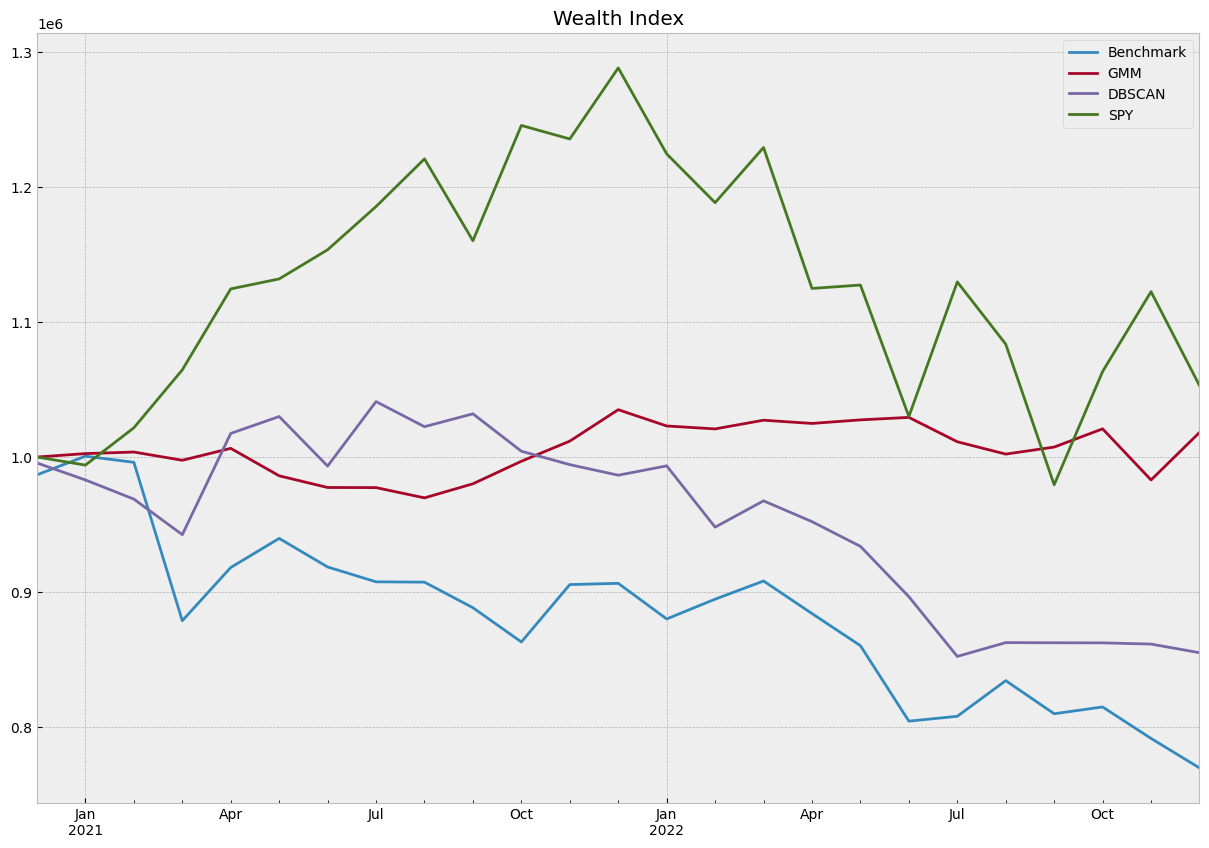

In [5]:
df_aum_bm = pd.read_csv(F"backtest/bm-historical_aum.csv",index_col=0)

df_aum_bm = df_aum_bm.set_index('date')
df_aum_bm.index = pd.to_datetime(df_aum_bm.index,format='%Y-%m-%d')

df_aum_bm = df_aum_bm.rename(columns={'aum':"Benchmark"})
df_aum_bm = df_aum_bm.iloc[1:,:]

df_aum_gmm = pd.read_csv(F"backtest/GMM-historical_aum.csv",index_col=0)

df_aum_gmm = df_aum_gmm.set_index('date')
df_aum_gmm.index = pd.to_datetime(df_aum_gmm.index,format='%Y-%m-%d')

df_aum_gmm = df_aum_gmm.rename(columns={'aum':"GMM"})
df_aum_gmm = df_aum_gmm.iloc[1:,:]

df_aum_dbscan = pd.read_csv(F"backtest/DBSCAN-historical_aum.csv",index_col=0)

df_aum_dbscan = df_aum_dbscan.set_index('date')
df_aum_dbscan.index = pd.to_datetime(df_aum_dbscan.index,format='%Y-%m-%d')

df_aum_dbscan = df_aum_dbscan.rename(columns={'aum':"DBSCAN"})
df_aum_dbscan = df_aum_dbscan.iloc[1:,:]

df_spy = pd.read_csv("backtest/SPY.csv",index_col=0)
df_spy = df_spy.rename(columns={"Adj Close":"SPY"})

df_spy = df_spy["SPY"]/df_spy.iloc[0]["SPY"] * 1000000

df_spy.index = pd.to_datetime(df_spy.index,format="%Y-%m-%d")

df_aum_combined = pd.concat([
                            df_aum_bm,
                            df_aum_gmm,
                            df_aum_dbscan,
                            df_spy
],axis=1)

df_aum_combined.plot(figsize=(15,10),title="Wealth Index")

In [6]:
vola_dict = volatility(df_aum_combined)
return_dict = holding_period_return(df_aum_combined)
max_dd = get_max_drawdown(df_aum_combined,0)
beta = get_beta(df_aum_combined)

run_time = [253,15,33,0]

### construct the dataframe
df_stat = pd.DataFrame(index=df_aum_combined.columns)

df_stat["HPR"] = df_stat.index.map(return_dict)
df_stat["Ann. Return"] = (df_stat["HPR"] +1) ** (1/2) -1
df_stat["Ann. Vola"] = df_stat.index.map(vola_dict)
df_stat["Sharpe Ratio"] = df_stat["Ann. Return"] / df_stat["Ann. Vola"]
df_stat["Beta"] = df_stat.index.map(beta)
df_stat["Max Drawdown"] = df_stat.index.map(max_dd)
df_stat["Total Runtime (mins)"] = run_time

df_stat.style.format({
    'HPR': '{:,.2%}'.format,
    'Ann. Return': '{:,.2%}'.format,
    'Ann. Vola': '{:,.2%}'.format,
    'Sharpe Ratio': '{:,.2f}'.format,
    'Beta': '{:,.2f}'.format,
    'Max Drawdown': '{:,.2%}'.format,
    'Total Runtime (mins)': '{:,.0f}'.format,
}).highlight_max(axis=0, props='color:green;').highlight_min(axis=0, props='color:red;')

,HPR,Ann. Return,Ann. Vola,Sharpe Ratio,Beta,Max Drawdown,Total Runtime (mins)
Benchmark,-22.00%,-11.68%,12.37%,-0.94,0.11,-23.08%,253
GMM,1.82%,0.91%,5.24%,0.17,-0.04,-5.03%,15
DBSCAN,-14.12%,-7.33%,9.97%,-0.74,0.04,-18.13%,33
SPY,5.30%,2.61%,19.25%,0.14,1.00,-23.97%,0
